In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler # StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

import joblib

np.random.seed(726)
torch.manual_seed(726)
torch.cuda.manual_seed(726)
torch.cuda.manual_seed_all(726)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [4]:
j = pd.read_csv('data/J(배).csv', header=0)
j.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/J(배).csv'

In [41]:
j['date'] = pd.to_datetime(j['date'])
j.set_index('date', inplace=True)

In [42]:
# 결측치 처리
j.loc[j['height1'] <= 1, 'height1'] = np.nan
median_value = j['height1'].median()
j['height1'] = j['height1'].fillna(median_value)

In [43]:
j.loc[j['height2'] <= 1, 'height2'] = np.nan
median_value = j['height2'].median()
j['height2'] = j['height2'].fillna(median_value)

In [44]:
j.loc[(j['in_flow'] > 800), 'in_flow'] = np.nan
j['in_flow'] = j['in_flow'].interpolate(method='linear')

In [45]:
j.loc[(j['in_flow'] < 0), 'in_flow'] = np.nan
j['in_flow'] = j['in_flow'].ffill()

In [46]:
j.loc[(j['out_flow'] > 800), 'out_flow'] = np.nan
j['out_flow'] = j['out_flow'].interpolate(method='linear')

In [47]:
j.loc[(j['out_flow'] < 0), 'out_flow'] = np.nan
j['out_flow'] = j['out_flow'].ffill()

In [48]:
j.describe()

,height1,height2,in_valve1,in_valve2,in_flow,out_valve1,out_valve2,out_flow
count,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000
mean,3.045,3.038,7651.998,150.048,325.797,74.439,6594.258,304.027
std,0.382,0.383,874445.828,17147.015,115.984,8506.669,753570.709,98.428
min,1.001,1.001,0.000,0.000,0.000,0.000,0.000,0.000
25%,2.816,2.796,0.000,0.000,258.900,0.000,0.000,231.978
50%,3.071,3.062,0.000,0.000,300.000,0.000,0.000,308.722
75%,3.313,3.316,0.000,0.000,366.100,0.000,0.000,369.000
max,4.019,4.069,99936460.000,1959678.000,800.000,972199.000,86124350.000,722.570


In [49]:
j = j.resample('h').mean()
j.head()

,height1,height2,in_valve1,in_valve2,in_flow,out_valve1,out_valve2,out_flow
date,,,,,,,,
2019-10-18 19:00:00,2.278,2.325,0.000,0.000,135.767,0.000,0.000,444.767
2019-10-18 20:00:00,2.325,2.368,0.000,0.000,451.579,0.000,0.000,352.897
2019-10-18 21:00:00,2.387,2.424,0.000,0.000,285.715,0.000,0.000,426.186
2019-10-18 22:00:00,2.389,2.421,0.000,0.000,269.691,0.000,0.000,336.389
2019-10-18 23:00:00,2.376,2.408,0.000,0.000,175.643,0.000,0.000,320.777


In [50]:
start_date = pd.Timestamp('2019-10-18 20:00:00')
end_date = pd.Timestamp('2022-06-30 23:59:00')
sample_df = j[(j.index >= start_date) & (j.index <= end_date)]
sample_df

,height1,height2,in_valve1,in_valve2,in_flow,out_valve1,out_valve2,out_flow
date,,,,,,,,
2019-10-18 20:00:00,2.325,2.368,0.000,0.000,451.579,0.000,0.000,352.897
2019-10-18 21:00:00,2.387,2.424,0.000,0.000,285.715,0.000,0.000,426.186
2019-10-18 22:00:00,2.389,2.421,0.000,0.000,269.691,0.000,0.000,336.389
2019-10-18 23:00:00,2.376,2.408,0.000,0.000,175.643,0.000,0.000,320.777
2019-10-19 00:00:00,2.416,2.464,0.000,0.000,381.217,0.000,0.000,293.171
...,...,...,...,...,...,...,...,...
2022-06-30 19:00:00,3.129,3.114,0.000,0.000,245.008,0.000,0.000,406.098
2022-06-30 20:00:00,2.987,2.977,0.000,0.000,244.290,0.000,0.000,434.142
2022-06-30 21:00:00,2.836,2.830,0.000,0.000,245.970,0.000,0.000,428.195


In [51]:
# 훈련, 검증, 테스트 세트로 나누기
train_start = start_date
train_end = pd.Timestamp('2021-08-31 23:00:00')
val_start = pd.Timestamp('2021-09-01 00:00:00')
val_end = pd.Timestamp('2022-01-31 23:00:00')
test_start = pd.Timestamp('2022-02-01 00:00:00')
test_end = end_date

In [52]:
train_set = sample_df.loc[train_start:train_end]
val_set = sample_df.loc[val_start:val_end]
test_set = sample_df.loc[test_start:test_end]

In [53]:
features = ['height1', 'height2', 'in_flow']
target = 'out_flow'

In [54]:
train_features = train_set[features]
train_target = train_set[[target]]
val_features = val_set[features]
val_target = val_set[[target]]
test_features = test_set[features]
test_target = test_set[[target]]

In [55]:
ft_scaler = MinMaxScaler()
tg_scaler = MinMaxScaler()

In [56]:
scaled_train_features = ft_scaler.fit_transform(train_features)
scaled_train_target = tg_scaler.fit_transform(train_target)
scaled_val_features = ft_scaler.transform(val_features)
scaled_val_target = tg_scaler.transform(val_target)
scaled_test_features = ft_scaler.transform(test_features)
scaled_test_target = tg_scaler.transform(test_target)

print(f'train_features의 shape', train_features.shape)
print(f'train_target의 shape', train_target.shape)
print(f'val_features의 shape', val_features.shape)
print(f'val_target의 shape', val_target.shape)
print(f'test_features의 shape', test_features.shape)
print(f'test_target의 shape', test_target.shape)

train_features의 shape (16396, 3)
train_target의 shape (16396, 1)
val_features의 shape (3672, 3)
val_target의 shape (3672, 1)
test_features의 shape (3600, 3)
test_target의 shape (3600, 1)


In [57]:
# 시퀀스 생성 함수
def create_sequences(features, target, input_seq_length, output_seq_length):
    xs, ys = [], []
    for i in range(len(features) - input_seq_length - output_seq_length + 1):
        x = features[i:i+input_seq_length]
        y = target[i+input_seq_length:i+input_seq_length+output_seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

input_seq_length = 48
output_seq_length = 24

In [58]:
X_train, y_train = create_sequences(scaled_train_features, scaled_train_target, input_seq_length, output_seq_length)
X_val, y_val = create_sequences(scaled_val_features, scaled_val_target, input_seq_length, output_seq_length)
X_test, y_test = create_sequences(scaled_test_features, scaled_test_target, input_seq_length, output_seq_length)

print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_val : {X_val.shape}')
print(f'y_val : {y_val.shape}')
print(f'X_test : {X_train.shape}')
print(f'y_test : {y_test.shape}')

X_train : (16325, 48, 3)
y_train : (16325, 24, 1)
X_val : (3601, 48, 3)
y_val : (3601, 24, 1)
X_test : (16325, 48, 3)
y_test : (3529, 24, 1)


In [59]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [60]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = 3
num_layers = 3
hidden_size = 64
output_size = output_seq_length

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [62]:
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [63]:
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [64]:
num_epochs = 50
patience = 10
verbose = 10

train_hist = []
val_hist = []

for epoch in range(num_epochs):
    total_train_loss = 0.0
    total_val_loss = 0.0

    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        batch_y = batch_y.squeeze(-1) # 마지막 차원을 제거
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for batch_X_val, batch_y_val in val_loader:
            batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
            batch_y_val = batch_y_val.squeeze(-1)
            predictions_val = model(batch_X_val)
            val_loss = loss_fn(predictions_val, batch_y_val)
            total_val_loss += val_loss.item()

    average_train_loss = total_train_loss / len(train_loader)
    average_val_loss = total_val_loss / len(val_loader)

    train_hist.append(average_train_loss)
    val_hist.append(average_val_loss)

    if (epoch + 1) % verbose == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}')

    if (epoch + 1) % patience == 0 and epoch + 1 != 0:
        if val_hist[-patience] < average_val_loss:
            print('\nEarly Stopping')
            break

Epoch [10/50] - Training Loss: 0.0081, Validation Loss: 0.0084
Epoch [20/50] - Training Loss: 0.0078, Validation Loss: 0.0081
Epoch [30/50] - Training Loss: 0.0061, Validation Loss: 0.0080
Epoch [40/50] - Training Loss: 0.0043, Validation Loss: 0.0082

Early Stopping


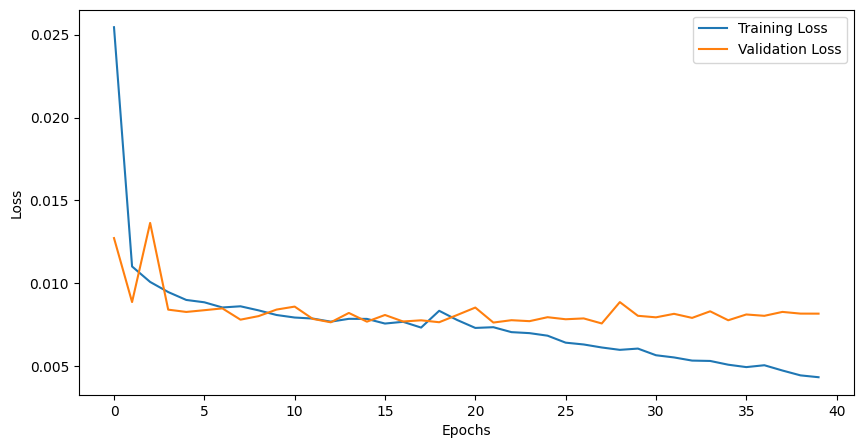

In [65]:
plt.figure(figsize=(10, 5))
plt.plot(train_hist, label='Training Loss')
plt.plot(val_hist, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [66]:
model.eval()
preds = []

with torch.no_grad():
    for batch_X_test, _ in test_loader:
        batch_X_test = batch_X_test.to(device)
        predictions_test = model(batch_X_test)
        preds.append(predictions_test.cpu().numpy())

preds = np.concatenate(preds, axis=0)

In [67]:
# 역변환하여 실제 값으로 변환
actual = tg_scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, output_seq_length))
predicted = tg_scaler.inverse_transform(preds.reshape(-1, output_seq_length))

In [73]:
# 테스트 구간의 날짜를 가져오기
dates = test_set.index[input_seq_length:-(output_seq_length-1)]

# 예측 및 실제 값의 길이를 확인
print(f'Length of dates: {len(dates)}')
print(f'Length of actual: {len(actual.flatten())}')
print(f'Length of predicted: {len(predicted.flatten())}')

# 비교 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Date': np.repeat(dates, output_seq_length),
    'Actual': actual.flatten(),
    'Predicted': predicted.flatten()
})

print(comparison_df)

Length of dates: 3529
Length of actual: 84696
Length of predicted: 84696
<bound method DataFrame.count of             Date  Actual  Predicted
0     2022-02-03 196.072    200.339
1     2022-02-03 184.871    177.258
2     2022-02-03 138.798    154.866
3     2022-02-03 131.191    131.417
4     2022-02-03 133.122    132.007
...          ...     ...        ...
84691 2022-06-30 406.098    344.260
84692 2022-06-30 434.142    341.536
84693 2022-06-30 428.195    370.728
84694 2022-06-30 364.893    391.866
84695 2022-06-30 312.118    364.881

[84696 rows x 3 columns]>


In [69]:
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f'LSTM RMSE: {rmse:.4f}')

LSTM RMSE: 48.2155


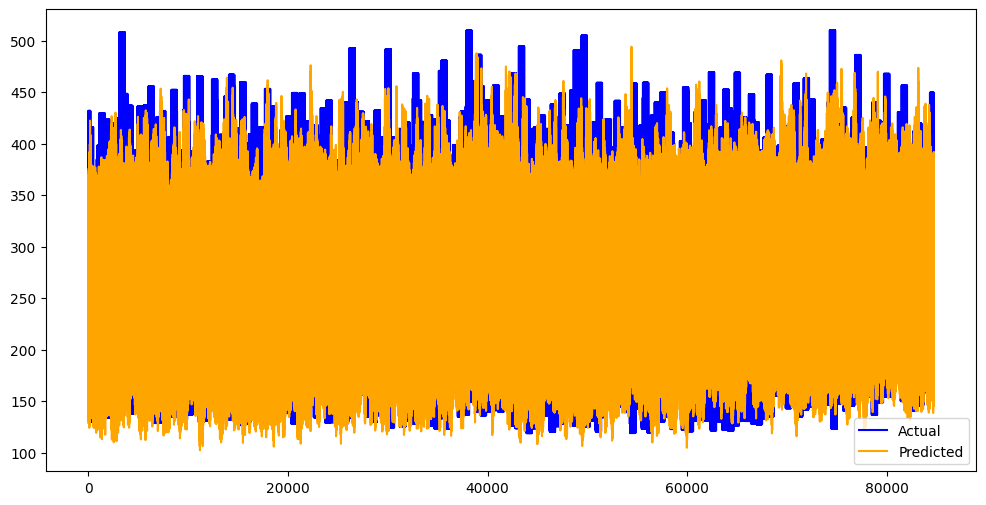

In [70]:
plt.figure(figsize=(12, 6))

# flatten된 시퀀스를 사용하여 길이를 맞추기
actual_flatten = actual.flatten()[:len(predicted.flatten())]

# 실제값과 예측값을 한 번씩만 플로팅
plt.plot(actual_flatten, label='Actual', color='blue')
plt.plot(predicted.flatten(), label='Predicted', color='orange')

plt.legend()
plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(actual, label='Actual', color='blue')
# plt.plot(predicted, label='Predicted', color='orange')
# plt.legend()
# plt.show()

In [71]:
# PATH = "LSTM_24.pth"
# torch.save(model, PATH)
# print(f"Model saved to {PATH}")

In [72]:
# joblib.dump(ft_scaler, 'ft24_scaler.pkl')
# joblib.dump(tg_scaler, 'tg24_scaler.pkl')